# Fun with the model
Let's make a filter like snapchat's

## Plan of attach
- Detect faces in an image
- Cut the region of interest (ROI) with some padding
- Feed the transformed ROI to the model and get the facial keypoints
- select important keypoints (the eye keypoints in this example)
- read the filter image (has to have an alpha chanel)
- replace pixel data from the ROI with those of the filter
- repaint the ROI on the main image

In [1]:
import cv2
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from datagenerator import FacialKeyPointsDataset
from tensorflow.keras.models import model_from_json
%matplotlib inline

TEST_IMG = "images/test5.jpg"

### Detect face
We'll use openCV for that.

In [2]:
def detectFace(image):
    # load in a haar cascade classifier for detecting frontal faces
    face_cascade = cv2.CascadeClassifier(
        'detector_architectures/haarcascade_frontalface_default.xml')

    # run the detector
    faces = face_cascade.detectMultiScale(image, 1.3, 10, 30)

    # make a copy of the original image to plot detections on
    image_with_detections = image.copy()

    # loop over the detected faces, mark the image where each face is found
    for (x, y, w, h) in faces:
        # draw a rectangle around each detected face
        cv2.putText(image_with_detections, 'Hooman', (x, y-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
        cv2.rectangle(image_with_detections, (x, y),
                      (x + w, y + h), (0, 0, 255), 3)

    return image_with_detections, faces

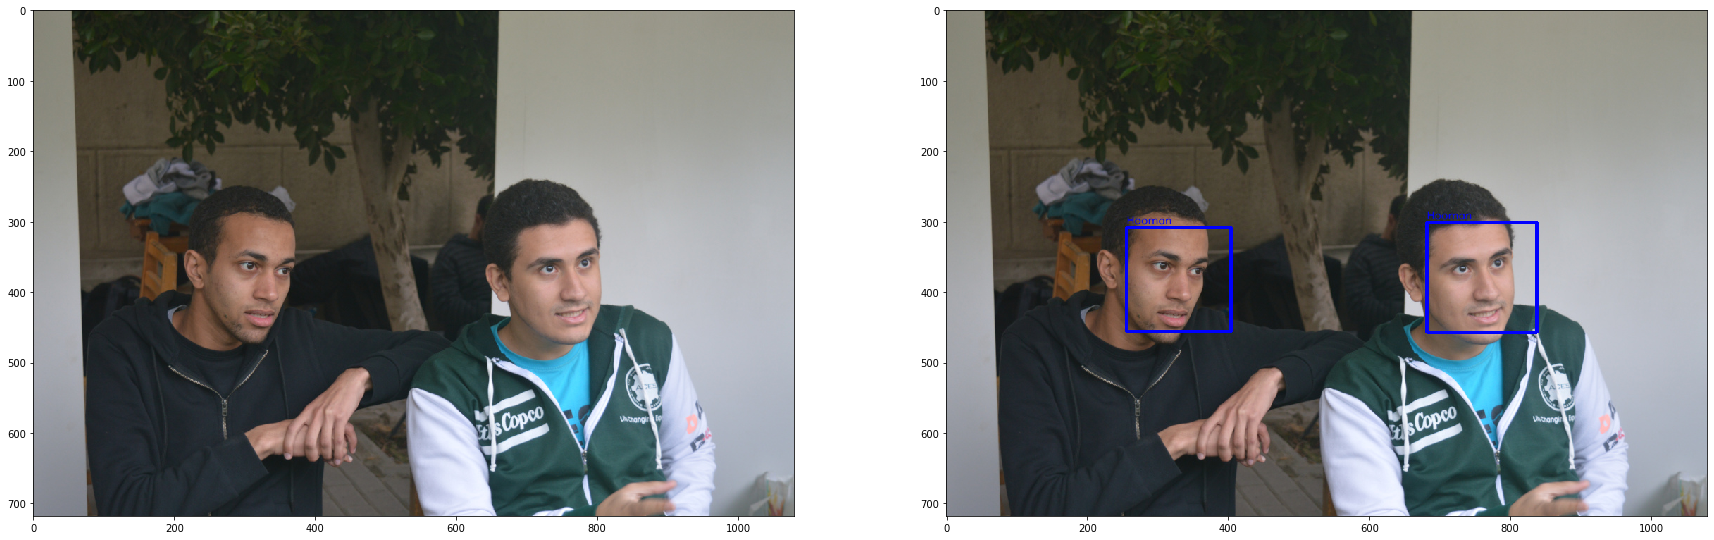

In [3]:
img = mpimg.imread(TEST_IMG)
img_with_faces, faces = detectFace(img)

plt.figure(figsize=(30, 30))

plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(img_with_faces)

### Cut the region of interest
simple array slicing

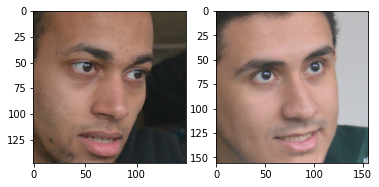

In [4]:
plt.figure(figsize=(3*len(faces), 3*len(faces)))
idx = 1
for (x, y, h, w) in faces:
    roi = img[y:y+h, x:x+w]
    plt.subplot(1, len(faces), idx)
    plt.imshow(roi)
    idx = idx + 1

### Get keypoints
We need to load the model first  
We also need to create an instance of the data generator to get the transformers and the mean, std vectors

In [5]:
# load json and create model
json_file = open(
    'models/model_vector_batchnorm_194.json',
    'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(
    "models/model_vector_batchnorm_194.h5")
print("Loaded model from disk")


datasetgen = FacialKeyPointsDataset(csv_file='data/training_frames_keypoints.csv',
                                    root_dir='data/training/',
                                    normalization="vector")

Loaded model from disk


In [6]:
def get_key_points(frame, face):
    # the padding, that guy has a huge chin that we need to be visible in the image
    pad = 50
    (x, y, w, h) = face
    # get the region of interes, this time with padding
    roi = frame[y - pad:y + h + pad, x - pad:x + w + pad]
    # we'll need the original size to rescale the image back to it
    originalSize = roi.shape
    if(originalSize[0] == 0 or originalSize[1] == 0):
        return (), roi, originalSize, (0, 0, 0, 0)
    
    roi = cv2.resize(roi, datasetgen.output_size)
    
    # preprocess the roi before prediction
    img = datasetgen.preprocess_test(roi)
    
    # make a batch from the image
    img = img.reshape(1, *img.shape, 1)
    keypts = model.predict(img).reshape(-1, 1)
    keypts = keypts * datasetgen.std + datasetgen.mean
    keypts = keypts.reshape(-1, 2)

    return keypts, roi, originalSize, (x-pad, y-pad, w+pad*2, h+pad*2)

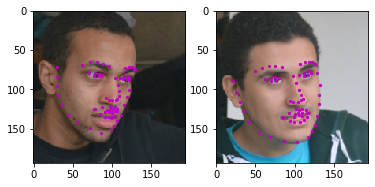

In [7]:
img = mpimg.imread(TEST_IMG)
plt.figure(figsize=(3*len(faces), 3*len(faces)))
idx = 1
for face in faces:
    keypts, roi, originalSize, padded = get_key_points(img, face)
    plt.subplot(1, len(faces), idx)
    plt.imshow(roi)
    plt.scatter(keypts[:, 0], keypts[:, 1], marker=".", s=20, color="m")
    idx = idx + 1

<img src="./images/absolute_win.jpg" /> 
### **Greate**
now let's get to business  
Of course if you train your model more than I did, or design a better architecture, you'll get better results
### Selecting important keypoints
Let's know the the index of the keypoint we want
<img src="./images/landmarks_numbered.jpg" width="400px" />
**NOTE**: These numbers start at 1, when we index them we'll start at 0 of course  
In this notebook we're gonna add glasses to the faces so 
- we need to pick a point to be the top lefthand corner of the image, point 18 seems good  
- We'll also need tow points to know the width we need to give the filter
- and two more for the height
- we could need to offset the origin of the filter
- we could need to add padding to the filter as well  
**OH!** I've got an idea, let's make a Class

In [8]:
class Filter:
    def __init__(self, path, coord, h_points, w_points, offset=(0, 0), padding=(0, 0)):
        self.img = mpimg.imread(path, -1)
        self.coord = coord
        self.h_points = h_points
        self.w_points = w_points
        self.offset = offset
        self.padding = padding
        
    def apply(self, keypts, roi):
        """ Apply the filter given the keypts on the given frame
        Args:
            keypts: the keypoints array
            roi: the face image to which you want to apply the filter
        """
        w = int(abs(
            keypts[ self.w_points[0] ][0] - keypts[ self.w_points[1] ][0]
        )) + self.padding[0]

        h = int(abs(
            keypts[ self.h_points[0] ][1] - keypts[ self.h_points[1] ][1]
        )) + self.padding[1]

        filter_img = cv2.resize(self.img, (w, h), interpolation=cv2.INTER_CUBIC)

        x = int(keypts[self.coord][0]) + self.offset[0]
        y = int(keypts[self.coord][1]) + self.offset[1]

        roi_color = roi[y:y + h, x:x + w]

        non_trans = np.argwhere(filter_img[:, :, 3] > 0)

        if(non_trans.shape[0] > roi_color.shape[0]*roi_color.shape[1]):
            return roi

        roi_color[non_trans[:, 0], non_trans[:, 1],
                  :3] = filter_img[non_trans[:, 0], non_trans[:, 1], :3]
        roi[y:y + h, x:x + w] = roi_color
        
        return roi
        

filter1 = Filter(
        path="images/filter1.png",
        coord=17,
        h_points=(25, 29),
        w_points=(2, 16),
        offset=(-10, 0)
)
# define more if you want



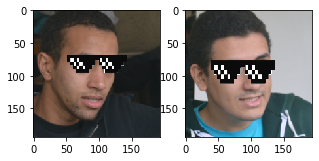

In [9]:
img = mpimg.imread(TEST_IMG)
plt.figure(figsize=(5, 5))
idx = 1
for face in faces:
    keypts, roi, originalSize, padded = get_key_points(img, face)
    plt.subplot(1, len(faces), idx)
    plt.imshow(filter1.apply(keypts, roi))
    idx = idx + 1

### This is greate.. 
Now let's put it all together

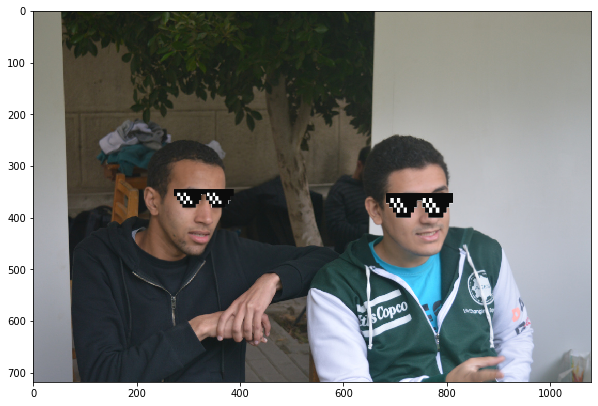

In [10]:
# Load the image
img = mpimg.imread(TEST_IMG).copy() # if you don't copy you'll get an immutable array and you don't want that

# detect faces
img_with_faces, faces = detectFace(img)

# iterate over faces and get keypoints for each face
for face in faces:
    keypts, roi, originalSize, (x, y, w, h) = get_key_points(img, face)
    roi = filter1.apply(keypts, roi)
    roi = cv2.resize(roi, (originalSize[:2]))
    img[y:y + h, x:x + w] = roi
    
plt.figure(figsize=(10, 10))
plt.imshow(img)
    
    


## Greate
If you've made it thus far, pat your self on the back, you will never be the same person again, you now know more  
In this repo you will find the files that combine all of this to make a live filter  
**Have Fun**